# Classification and localization of dogs and cats

In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torchvision.models import inception_v3, resnet18
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import xmltodict
import random
import matplotlib.pyplot as plt
import time
import copy

## Create dataset

In [2]:
DATASET_PATH = '/home/grzetan/datasets/classification_and_localization'
ANNOTATIONS = 'annotations/annotations/xmls'
IMAGES = 'images/images'

In [3]:
class DogsAndCatsDataset(Dataset):
    def __init__(self, path=DATASET_PATH, imgs_path=IMAGES, ann_path=ANNOTATIONS,transforms=None):
        self.transforms = transforms
        self.imgs_path = os.path.join(path, imgs_path)
        self.ann_path = os.path.join(path, ann_path)
        self.annotations = os.listdir(self.ann_path)
        self.classes = []
        self.bnd_boxes = []
        self.labels = []
        self.img_paths = []
        for ann in self.annotations:
                cls = '_'.join(ann.split('_')[:-1])
                if cls not in self.classes:
                    self.classes.append(cls)
                
                self.labels.append(self.classes.index(cls))
                with open(os.path.join(self.ann_path, ann), 'r') as f:
                    m = xmltodict.parse(f.read())
                    self.img_paths.append(m['annotation']['filename'])
                    bndbox = m['annotation']['object']['bndbox']
                    box = [int(val) for val in bndbox.values()]
                    self.bnd_boxes.append(box)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.imgs_path, self.img_paths[idx]))
        bndbox = self.bnd_boxes[idx]
        label = self.labels[idx]
        sample = {'img': img, 'bndbox': bndbox, 'label': label}
        if self.transforms:
            sample = self.transforms(sample)
        
        return sample
        
    def __len__(self):
        return len(self.labels)

# Transforms
class Resize(object):
    def __init__(self, size=299):
        self.size=size
    
    def __call__(self, sample):
        old_size = sample['img'].size
        x_ratio = self.size / old_size[0]
        y_ratio = self.size / old_size[1]
        sample['bndbox'][0] *= x_ratio
        sample['bndbox'][1] *= y_ratio
        sample['bndbox'][2] *= x_ratio
        sample['bndbox'][3] *= y_ratio
        sample['img'] = sample['img'].resize((self.size, self.size))
        
        return sample

class ToTensor(object):
    def __call__(self, sample):
        size = sample['img'].size
        sample['img'] = np.asarray(sample['img'])
        sample['img'] = sample['img'] / 255
        sample['img'] = sample['img'].transpose((2,0,1))
        sample['img'] = torch.from_numpy(sample['img']).to(torch.float)
        sample['bndbox'] = [val / size[0] for val in sample['bndbox']]
        sample['bndbox'] = torch.tensor(sample['bndbox'], dtype=torch.float32)
        sample['label'] = torch.tensor(sample['label'], dtype=torch.int64)
        
        return sample
    
class Normalize(object):
    def __init__(self, mean=[0.4451, 0.4262, 0.3959], std=[0.2411, 0.2403, 0.2466]):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
    
    def __call__(self, sample):
        sample['img'] = (sample['img'] - self.mean[:,None,None]) / self.std[:,None,None]
        return sample
        

pipeline = Compose([
    Resize(),
    ToTensor(),
    Normalize()
])
        
dataset = DogsAndCatsDataset(transforms=pipeline)
test_len = int(0.2 * len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset) - test_len, test_len])

train_loader = DataLoader(train_set, batch_size=16)
val_loader = DataLoader(val_set, batch_size=16)

## Visualize data

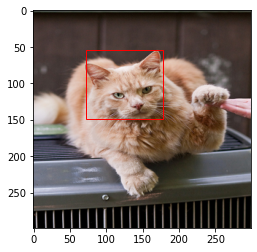

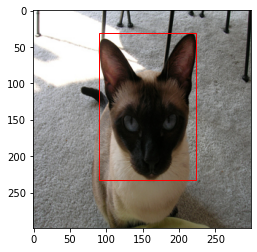

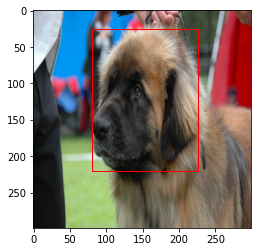

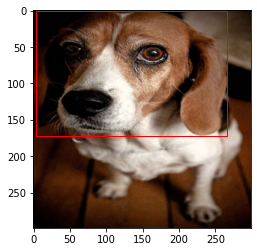

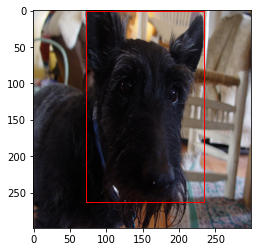

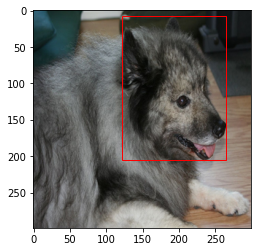

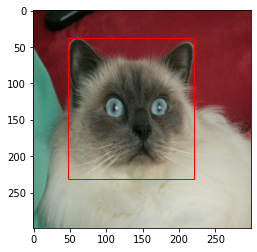

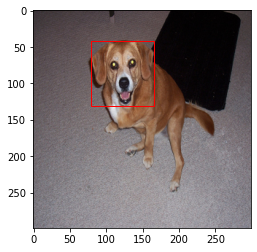

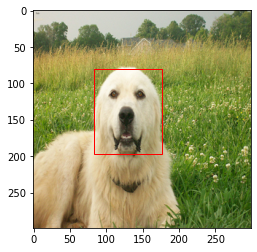

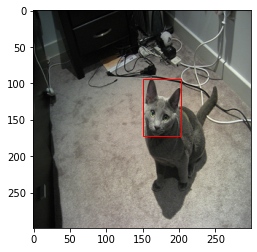

In [4]:
tmp_dataset = DogsAndCatsDataset(transforms=Compose([Resize()]))
for i in range(10):
    sample = tmp_dataset[i]
    img = np.array(sample['img'])
    bbox = sample['bndbox']
    label = sample['label']
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

## Create model

In [5]:
class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        
    def forward(self, X):
        return X

class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        self.backbone = resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.dropout = EmptyLayer()
        self.backbone.fc = EmptyLayer()
        
        self.cls = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, n_classes),
            nn.Softmax(dim=1)
        )
        
#         self.loc = nn.Sequential(
#             nn.Linear(in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(128, 4)
#         )
        
    def freeze_backbone(self, b):
        for p in self.backbone.parameters():
            p.requires_grad = not b
    
    def forward(self, X):
        X = self.backbone(X)
        cls = self.cls(X)
#       loc = self.loc(X.logits)
        
        return cls

## Loss 

In [6]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.lambda_cls = 1
        self.lambda_loc = 1
    
    def iou(self, preds, label):
        x1 = torch.max(preds[...,0:1], label[...,0:1])
        y1 = torch.max(preds[...,1:2], label[...,1:2])
        x2 = torch.max(preds[...,2:3], label[...,2:3])
        y2 = torch.max(preds[...,3:4], label[...,3:4])
        
        intersection = (x2 - x1) * (y2 - y1)
        preds_area = (preds[...,2:3] - preds[...,0:1]) * (preds[...,3:4] - preds[...,1:2])
        label_area = (label[...,2:3] - label[...,0:1]) * (label[...,3:4] - label[...,1:2])

        return intersection / (preds_area + label_area - intersection + 1e-6)
    
    def forward(self, cls, label, bndbox):
        cls_loss = self.ce(cls, label)
#         loc_loss = self.iou(loc, bndbox)
        
        return cls_loss
        

In [7]:
def train_model(model, optimizer, criterion, epochs=10):
    start = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f'\nEpoch {epoch+1}/{epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
            
            running_loss = 0.0
            running_acc = 0.0
            running_mse = 0.0
            
            for i, batch in enumerate(loader):
                print(f'\r{phase} phase: {round((i / len(loader) * 100), 2) }%', end='')
                optimizer.zero_grad()
                inputs, bndbox, label = batch['img'], batch['bndbox'], batch['label']
                inputs = inputs.to(device)
                bndbox = bndbox.to(device)
                label = label.to(device)
                
                with torch.set_grad_enabled(phase=='train'):
                    cls = model(inputs)
                    _, preds = torch.max(cls, 1)
                    total_loss = criterion(cls, label, bndbox)
                    
                    if phase=='train':
                        total_loss.backward()
                        optimizer.step()
                        
                    running_loss += total_loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == label)
                    
            # Stats
            epoch_loss = running_loss / len(loader)
            epoch_acc = running_acc / (len(loader) * 16)
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_weights = copy.deepcopy(model.state_dict())
            print(f'\r{phase} - loss: {round(epoch_loss, 5)}, accuracy - {round(float(epoch_acc),4)}')
            
        print(f'Epoch completed in {int(time.time() - epoch_start) // 60} min {int(time.time() - epoch_start) % 60} sec')
    t = time.time() - start
    print(f'\nTraining completed in {int(time.time() - start) // 60} min {int(time.time() - start) % 60} sec')
    model.load_state_dict(best_weights)
    return model     

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Model(len(dataset.classes))
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = Loss()

model.freeze_backbone(True)
model = train_model(model, optimizer, criterion, epochs=5)
torch.save(model.state_dict(), '/home/grzetan/PYTHON/Exercises-From-Hands-On-Machine-Learning/14-ComputerVision/with_freezed_layers_loc')


Epoch 1/5
train - loss: 57.52743, accuracy - 0.0466
val - loss: 57.7482, accuracy - 0.1019
Epoch completed in 0 min 40 sec

Epoch 2/5
train - loss: 57.49176, accuracy - 0.102
val - loss: 57.70505, accuracy - 0.1264
Epoch completed in 0 min 40 sec

Epoch 3/5
train - loss: 57.42981, accuracy - 0.1149
val - loss: 57.61751, accuracy - 0.0883
Epoch completed in 0 min 38 sec

Epoch 4/5
train - loss: 57.13687, accuracy - 0.0828
val - loss: 57.10374, accuracy - 0.0761
Epoch completed in 0 min 38 sec

Epoch 5/5
train - loss: 56.13943, accuracy - 0.1389
val - loss: 56.18177, accuracy - 0.144
Epoch completed in 0 min 37 sec

Training completed in 3 min 14 sec


## With unfreezed backbone parameters

In [ ]:
torch.cuda.empty_cache()
model.freeze_backbone(False)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = Loss()

model = train_model(model, optimizer, criterion, epochs=3)


Epoch 1/3
train - loss: 54.29835, accuracy - 0.2736
val - loss: 53.37434, accuracy - 0.3438
Epoch completed in 1 min 5 sec

Epoch 2/3
train phase: 58.38%